In [1]:
import sys, os
import numpy as np
import time, h5py
codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import default_paths, coco_utils, nsd_utils, numpy_utils 
from utils import stats_utils, segmentation_utils, prf_utils, texture_utils
from model_fitting import initialize_fitting 
from feature_extraction import texture_statistics_pyramid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import argparse
import pandas as pd
from skimage import io
import copy

from matplotlib import pyplot as plt
import PIL



Initializing coco api...
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
loading annotations into memory...
Done (t=14.82s)
creating index...
index created!
Initializing coco api...
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
loading annotations into memory...
Done (t=12.64s)
creating index...
index created!


In [2]:
coco_utils.write_indoor_outdoor_csv(subject=1)

things labels assumed to be indoor:
['couch' 'potted plant' 'bed' 'dining table' 'toilet' 'tv' 'mouse'
 'remote' 'keyboard' 'microwave' 'oven' 'toaster' 'sink' 'refrigerator'
 'clock' 'vase' 'hair drier' 'toothbrush']
things labels assumed to be outdoor:
['car' 'motorcycle' 'airplane' 'bus' 'train' 'truck' 'boat'
 'traffic light' 'fire hydrant' 'stop sign' 'parking meter' 'bench'
 'horse' 'sheep' 'cow' 'elephant' 'bear' 'zebra' 'giraffe' 'frisbee'
 'skis' 'snowboard' 'sports ball' 'kite' 'baseball bat' 'baseball glove'
 'skateboard' 'surfboard' 'tennis racket']
things labels that are ambiguous:
['person' 'bicycle' 'bird' 'cat' 'dog' 'backpack' 'umbrella' 'handbag'
 'tie' 'suitcase' 'bottle' 'wine glass' 'cup' 'fork' 'knife' 'spoon'
 'bowl' 'banana' 'apple' 'sandwich' 'orange' 'broccoli' 'carrot' 'hot dog'
 'pizza' 'donut' 'cake' 'chair' 'laptop' 'cell phone' 'book' 'scissors'
 'teddy bear']
stuff labels assumed to be indoor:
['cabinet' 'carpet' 'ceiling-other' 'ceiling-tile' 'counter' 

In [66]:
subject = 1
indoor_outdoor_df = pd.read_csv('/user_data/mmhender/nsd_stimuli/labels/S1_indoor_outdoor.csv')

cat_objects, cat_names, cat_ids, supcat_names, ids_each_supcat = \
            coco_utils.get_coco_cat_info(coco_utils.coco_val)
stuff_cat_objects, stuff_cat_names, stuff_cat_ids, stuff_supcat_names, stuff_ids_each_supcat = \
            coco_utils.get_coco_cat_info(coco_utils.coco_stuff_val)


['bicycle' 'chair' 'potted plant']
['floor-other' 'house' 'other']


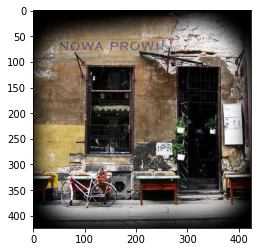

In [31]:
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_binary.csv'%subject)
coco_df = pd.read_csv(fn2load, index_col = 0)
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_stuff_binary.csv'%subject)
coco_stuff_df = pd.read_csv(fn2load, index_col = 0)

conflict = np.sum(np.array(indoor_outdoor_df)==1, axis=1)==2

image_ind = np.random.choice(np.where(conflict)[0], 1)[0]
subject_df = nsd_utils.get_subj_df(subject=1)
cocoid = subject_df['cocoId'].iloc[image_ind]

# loading the image from two different places to make sure it is the same one   
cocoid = np.array(subject_df['cocoId'])[image_ind]
cocoim = '/lab_data/tarrlab/common/datasets/NSD_images/images/%d.jpg'%cocoid
im = PIL.Image.open(cocoim)

plt.figure();
plt.imshow(im)

binary_cat_in_image = np.array(coco_df.loc[image_ind])[12:92]
cat_in_image = np.array(cat_names)[binary_cat_in_image==1]
print(cat_in_image)

binary_stuff_cat_in_image = np.array(coco_stuff_df.loc[image_ind])[16:108]
stuff_cat_in_image = np.array(stuff_cat_names)[binary_stuff_cat_in_image==1]
print(stuff_cat_in_image)


['knife' 'apple']
['other']


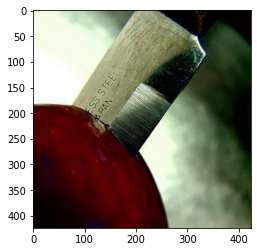

In [41]:
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_binary.csv'%subject)
coco_df = pd.read_csv(fn2load, index_col = 0)
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_stuff_binary.csv'%subject)
coco_stuff_df = pd.read_csv(fn2load, index_col = 0)

ambiguous = np.sum(np.array(indoor_outdoor_df)==1, axis=1)==0

image_ind = np.random.choice(np.where(ambiguous)[0], 1)[0]
subject_df = nsd_utils.get_subj_df(subject=1)
cocoid = subject_df['cocoId'].iloc[image_ind]

# loading the image from two different places to make sure it is the same one   
cocoid = np.array(subject_df['cocoId'])[image_ind]
cocoim = '/lab_data/tarrlab/common/datasets/NSD_images/images/%d.jpg'%cocoid
im = PIL.Image.open(cocoim)

plt.figure();
plt.imshow(im)

binary_cat_in_image = np.array(coco_df.loc[image_ind])[12:92]
cat_in_image = np.array(cat_names)[binary_cat_in_image==1]
print(cat_in_image)

binary_stuff_cat_in_image = np.array(coco_stuff_df.loc[image_ind])[16:108]
stuff_cat_in_image = np.array(stuff_cat_names)[binary_stuff_cat_in_image==1]
print(stuff_cat_in_image)


['person' 'cake']
['curtain' 'table' 'wall-other' 'other']


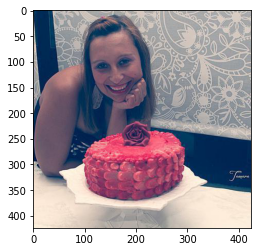

In [57]:
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_binary.csv'%subject)
coco_df = pd.read_csv(fn2load, index_col = 0)
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_stuff_binary.csv'%subject)
coco_stuff_df = pd.read_csv(fn2load, index_col = 0)

indoor = np.array(indoor_outdoor_df['has_indoor'])==1

image_ind = np.random.choice(np.where(indoor)[0], 1)[0]
subject_df = nsd_utils.get_subj_df(subject=1)
cocoid = subject_df['cocoId'].iloc[image_ind]

# loading the image from two different places to make sure it is the same one   
cocoid = np.array(subject_df['cocoId'])[image_ind]
cocoim = '/lab_data/tarrlab/common/datasets/NSD_images/images/%d.jpg'%cocoid
im = PIL.Image.open(cocoim)

plt.figure();
plt.imshow(im)

binary_cat_in_image = np.array(coco_df.loc[image_ind])[12:92]
cat_in_image = np.array(cat_names)[binary_cat_in_image==1]
print(cat_in_image)

binary_stuff_cat_in_image = np.array(coco_stuff_df.loc[image_ind])[16:108]
stuff_cat_in_image = np.array(stuff_cat_names)[binary_stuff_cat_in_image==1]
print(stuff_cat_in_image)


['person' 'airplane']
['grass' 'sky-other' 'tree' 'other']


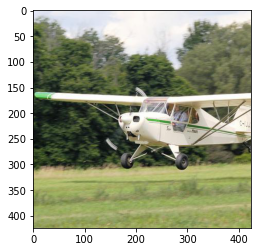

In [64]:
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_binary.csv'%subject)
coco_df = pd.read_csv(fn2load, index_col = 0)
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_stuff_binary.csv'%subject)
coco_stuff_df = pd.read_csv(fn2load, index_col = 0)

outdoor = np.array(indoor_outdoor_df['has_outdoor'])==1

image_ind = np.random.choice(np.where(outdoor)[0], 1)[0]
subject_df = nsd_utils.get_subj_df(subject=1)
cocoid = subject_df['cocoId'].iloc[image_ind]

# loading the image from two different places to make sure it is the same one   
cocoid = np.array(subject_df['cocoId'])[image_ind]
cocoim = '/lab_data/tarrlab/common/datasets/NSD_images/images/%d.jpg'%cocoid
im = PIL.Image.open(cocoim)

plt.figure();
plt.imshow(im)

binary_cat_in_image = np.array(coco_df.loc[image_ind])[12:92]
cat_in_image = np.array(cat_names)[binary_cat_in_image==1]
print(cat_in_image)

binary_stuff_cat_in_image = np.array(coco_stuff_df.loc[image_ind])[16:108]
stuff_cat_in_image = np.array(stuff_cat_names)[binary_stuff_cat_in_image==1]
print(stuff_cat_in_image)


In [67]:
supcat_names


['accessory',
 'animal',
 'appliance',
 'electronic',
 'food',
 'furniture',
 'indoor',
 'kitchen',
 'outdoor',
 'person',
 'sports',
 'vehicle']

In [72]:
for sc in range(len(supcat_names)):
    print(supcat_names[sc])
    print([cat_names[cc] for cc in range(len(cat_names)) if cat_ids[cc] in ids_each_supcat[sc] ])

accessory
['backpack', 'umbrella', 'handbag', 'tie', 'suitcase']
animal
['bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe']
appliance
['microwave', 'oven', 'toaster', 'sink', 'refrigerator']
electronic
['tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone']
food
['banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake']
furniture
['chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet']
indoor
['book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
kitchen
['bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl']
outdoor
['traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
person
['person']
sports
['frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket']
vehicle
['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat']
